In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
import ct_projector.projector.numpy as ct_projector
import ct_projector.projector.numpy.parallel as ct_para
import ct_projector.prior.numpy as ct_prior
import ct_projector.recon.numpy as ct_recon

print('recon backend used: ', ct_recon.get_backend())

recon backend used:  numpy


In [3]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
img = np.copy(img, 'C')
spacing = np.array(spacing[::-1])

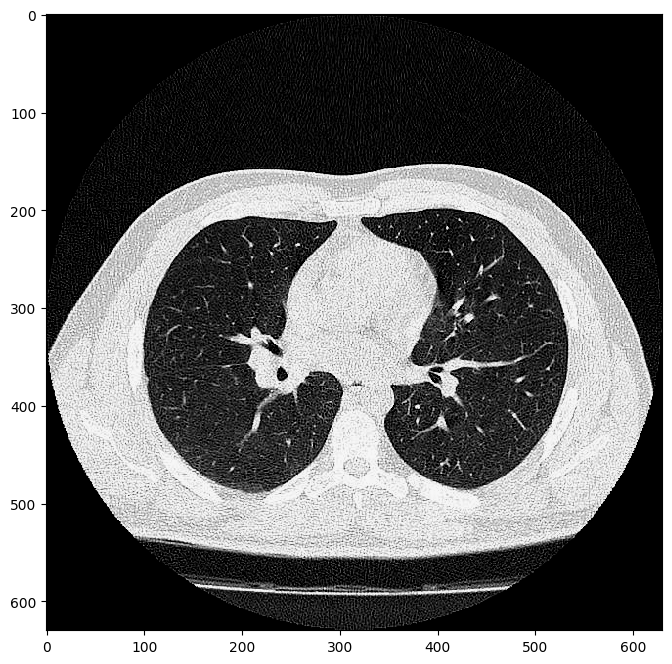

In [4]:
img_ref = img[:, [img.shape[1]//2], ...]

plt.figure(figsize=[8, 8])
plt.imshow(img_ref[0, 0], 'gray', vmin=0, vmax=1.2)

In [5]:
device = 0
down_rate = 16

In [6]:
projector = ct_projector.ct_projector()
projector.from_file('projector_fan.cfg')
projector.nv = 1
projector.nz = 1
projector.ny = img_ref.shape[2]
projector.nx = img_ref.shape[3]
projector.du = projector.du * projector.dso / projector.dsd
angles = projector.get_angles()
angles_sparse = np.copy(angles[::down_rate], 'C')

In [7]:
ct_projector.set_device(device)
ct_prior.set_device(device)

ref = np.array(img_ref, order='C')
angles = np.array(angles, order='C')
angles_sparse = np.array(angles_sparse, order='C')

projector.set_projector(ct_para.distance_driven_fp, angles=angles_sparse)
projector.set_backprojector(ct_para.distance_driven_bp, angles=angles_sparse)

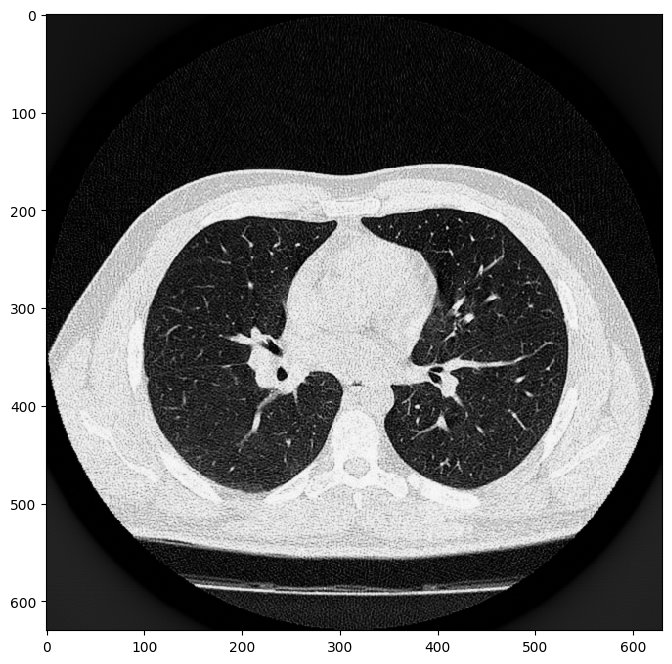

In [8]:
prj = projector.fp(ref, angles=angles)
fprj = ct_para.ramp_filter(projector, prj, 'rl')
fbp = ct_para.distance_driven_bp(projector, fprj, angles, True)

plt.figure(figsize=[8, 8])
plt.imshow(fbp[0, 0], 'gray', vmin=0, vmax=1.2)

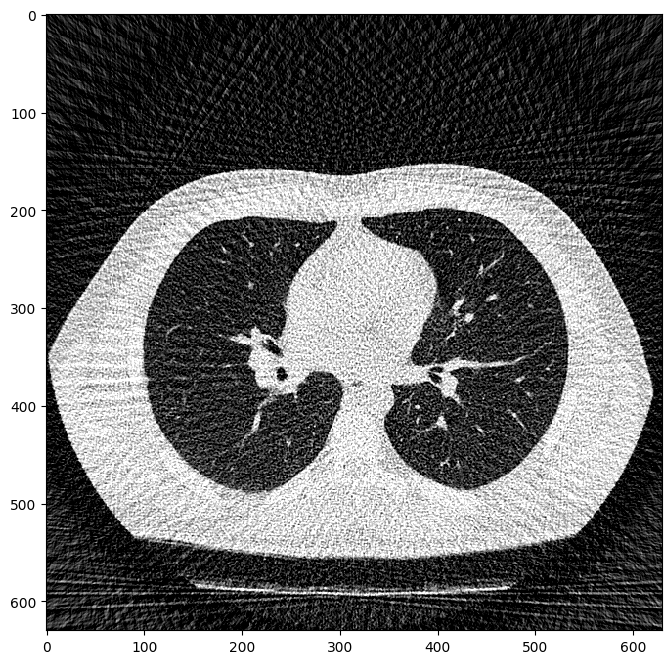

In [9]:
prj_sparse = projector.fp(ref, angles=angles_sparse)
fprj = ct_para.ramp_filter(projector, prj_sparse, 'rl')
fbp_sparse = ct_para.distance_driven_bp(projector, fprj, angles_sparse, True)

plt.figure(figsize=[8, 8])
plt.imshow(fbp_sparse[0, 0], 'gray', vmin=0, vmax=1.2)

In [10]:
# TV reconstruction
niter = 1000
nos = 12
nesterov = 0.5
beta = 0.0001
zero_init = True

projector.nview = len(angles_sparse)
projector_norm = projector.calc_projector_norm()
norm_img = projector.calc_norm_img() / projector_norm / projector_norm

fbp_sparse = np.array(fbp_sparse, order='C')
if zero_init:
    recon = np.zeros(fbp_sparse.shape, np.float32)
    nesterov_img = np.zeros(fbp_sparse.shape, np.float32)
else:    
    recon = np.copy(fbp_sparse)
    nesterov_img = np.copy(recon)

for i in range(niter):
    for os in range(nos):
        inds = np.arange(os, len(angles_sparse), nos)
        angles_current = np.copy(angles_sparse[inds], 'C')
        prj_current = np.copy(prj_sparse[:, inds, ...], 'C')

        recon = ct_recon.sqs_one_step(
            projector,
            nesterov_img,
            prj_current,
            norm_img,
            projector_norm,
            beta,
            ct_prior.tv_sqs,
            {'weights': [1, 1, 1]},
            nos,
            {'angles': angles_current},
            {'angles': angles_current},
            return_loss=False
        )

        nesterov_img = recon + nesterov * (recon - nesterov_img)

    _, data_loss, tv_loss = ct_recon.sqs_one_step(
        projector,
        recon,
        prj_sparse,
        norm_img,
        projector_norm,
        beta,
        ct_prior.tv_sqs,
        {'weights': [1, 1, 1]},
        1,
        return_loss=True
    )

    if (i + 1) % 100 == 0:
        print(i + 1, data_loss, tv_loss)

0,1,2,3,4,5,6,7,8,9,
100 0.2438288927078247 14077.144
200 0.2494385987520218 13257.799
300 0.253122478723526 12908.918
400 0.2555074989795685 12729.961
500 0.2569983899593353 12633.481
600 0.25801584124565125 12579.3955
700 0.25868725776672363 12548.712
800 0.259164035320282 12530.149
900 0.2595062851905823 12518.511
1000 0.259726345539093 12511.381


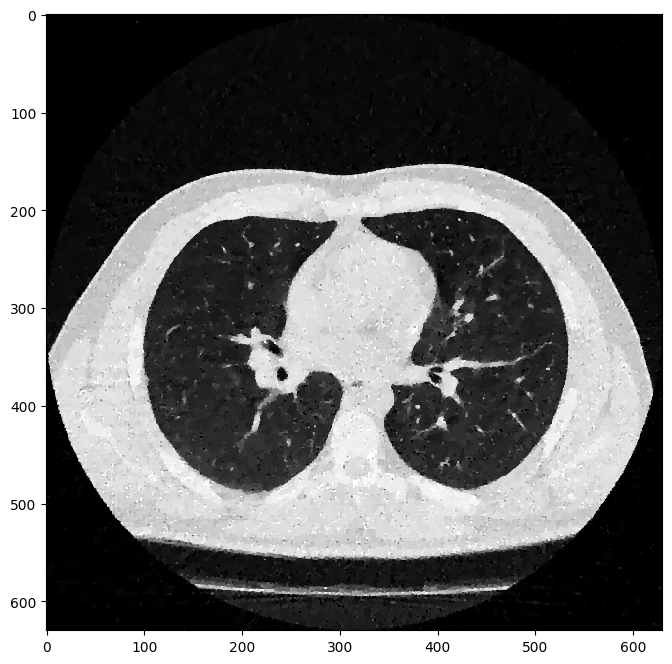

In [11]:
plt.figure(figsize=[8, 8])
plt.imshow(recon[0, 0], 'gray', vmin=0, vmax=1.2)